Regression Model to Predict Affinity from Protein Sequences using AlphaSeq Dataset

*Quantile Regression with XGBoost*

Andrew Kiruluta, 04/02/2023

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import ast
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_pinball_loss, mean_squared_error
torch.manual_seed(5)

In [2]:
# load processed data from the EDA notebook
df3 = pd.read_csv('data/20230331_pembro_SSMplus_AlphaSeq_data_unique_embedding.csv')

In [3]:
# scale target Kd column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df3[['Kd']] = scaler.fit_transform(df3[['Kd']])

In [4]:
# lest us embedd the protein tokens
VOCAB_SIZE = 252
tok_emb = nn.Embedding(VOCAB_SIZE, 1)
def embedding2(seq):
    return tok_emb(torch.tensor(seq,dtype=torch.long)).detach().numpy()

df3['embedding'] = df3.apply(lambda x: embedding2(ast.literal_eval(x["embedding"])).flatten(), axis=1)


In [5]:
X = pd.DataFrame.from_records(df3['embedding'])
y = df3['Kd'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# *Grid Search GradientBoostingRegressor*

In [ ]:
model = GradientBoostingRegressor(loss="quantile", alpha=0.5)
grid = dict()
grid['n_estimators'] = [10, 50, 100, 400, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9, 100, 200,300]
grid['min_samples_leaf'] = [0.5, 0.7, 1.0, 10, 20]
grid['min_samples_split'] = [1.0, 10, 20]
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [52]:
all_models = {}
common_params = dict(    # best so far
    learning_rate=0.05,   # 0.05
    n_estimators=2800,     # 400, 1800
    max_depth=200,         # 200
    min_samples_leaf=20,  # 20
    min_samples_split=20, # 20
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

In [ ]:
# save trained models to JSON for later inference
pickle.dump([all_models["q 0.05"],all_models["q 0.50"],all_models["q 0.95"],all_models["mse"]], open("data/Trained_Model.pkl", "wb"))

In [53]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(all_models["mse"], X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.077 (0.001)


# *Load Model for Inferemce on Test Data*

In [ ]:
model2 = GradientBoostingRegressor()
model2.load_model('model/model_05.json')

In [54]:
y_pred = all_models["mse"].predict(X_test)
y_lower = all_models["q 0.05"].predict(X_test)
y_upper = all_models["q 0.95"].predict(X_test)
y_med = all_models["q 0.50"].predict(X_test)

In [55]:
results = pd.DataFrame()
results['y_test'] = y_test
results['y_pred'] = y_pred

# *Pearson Correlation*

In [57]:
from  scipy import stats
results = pd.DataFrame()
results['y_test'] = y_test
results["y_pred"] = y_med
print("Pearson Correlation, Test Data: %.2f" %(np.corrcoef(y_test,y_pred)[0,1]))


Pearson Correlation, Test Data: 0.81


In [32]:
y_med

array([0.72249891, 0.72166857, 0.75364837, ..., 0.64629535, 0.47238661,
       0.56316658])

# *Prediction Vs Measured Scatter Plots*

Text(0, 0.5, 'y_pred')

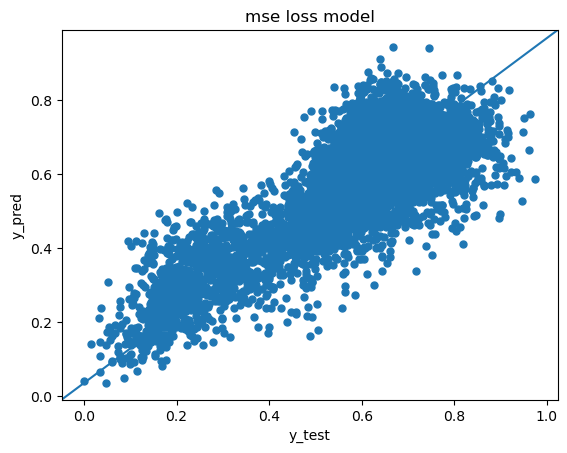

In [51]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, zorder=10)
ax.plot([0,1],[0,1], transform=ax.transAxes)
plt.title('mse loss model')
plt.xlabel('y_test')
plt.ylabel('y_pred')

Text(0, 0.5, 'y_lower')

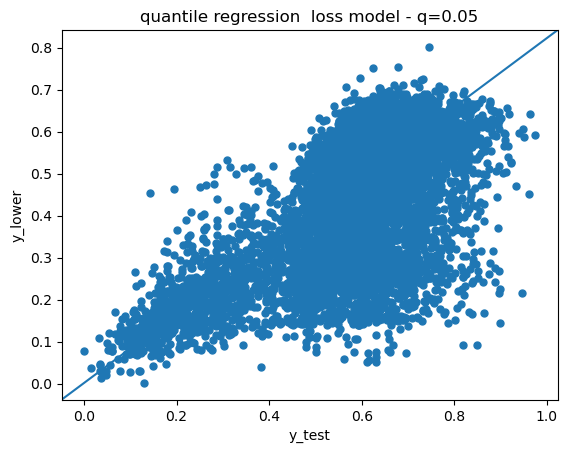

In [13]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_lower, s=25, zorder=10)
ax.plot([0,1],[0,1], transform=ax.transAxes)
plt.title('quantile regression  loss model - q=0.05')
plt.xlabel('y_test')
plt.ylabel('y_lower')

Text(0, 0.5, 'y_upper')

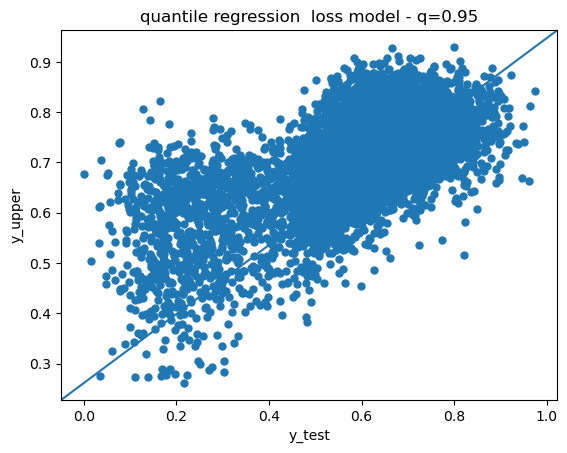

In [14]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_upper, s=25, zorder=10)
ax.plot([0,1],[0,1], transform=ax.transAxes)
plt.title('quantile regression  loss model - q=0.95')
plt.xlabel('y_test')
plt.ylabel('y_upper')

Text(0, 0.5, 'y_med')

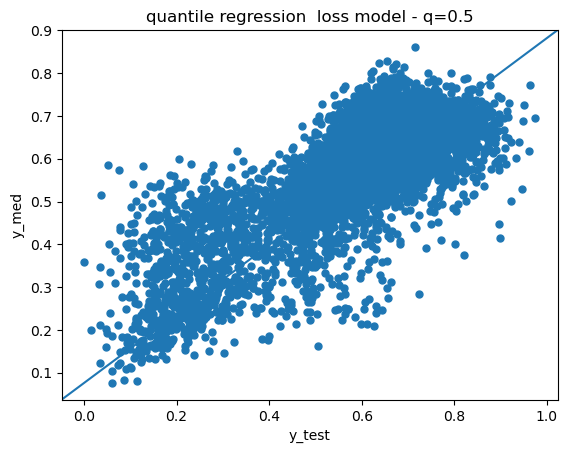

In [15]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_med, s=25, zorder=10)
ax.plot([0,1],[0,1], transform=ax.transAxes)
plt.title('quantile regression  loss model - q=0.5')
plt.xlabel('y_test')
plt.ylabel('y_med')

In [16]:

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results = []
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    y_pred = gbr.predict(X_test)
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_test, y_pred, alpha=alpha)
    metrics["MSE"] = mean_squared_error(y_test, y_pred)
    results.append(metrics)

pd.DataFrame(results).set_index("model").style.apply(highlight_min)

,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,0.036579,0.038039,0.039499,0.009818
q 0.05,0.011786,0.080502,0.149219,0.042838
q 0.50,0.036025,0.038476,0.040927,0.010742
q 0.95,0.129908,0.071338,0.012769,0.032286
